# MY475 Seminar 3: Convolutional neural networks and autoencoders

In this seminar, we are going to study working with image data using both *convolutional neural networks* (CNNs) and *(variational) autoencoders*.

As normal, we will build our networks in three stages:

1. Format the input data
2. Design the neural network architecture
3. Train the model

Our first dataset is the cannonical [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, a set of handwritten digits with the corresponding numerical label from 0-9. The first task is to recognise which digit each handwritten example represents, making this a *multi-class classification problem* as there are 10 outcome classes (0, 1,...,9).

## Exercise 0. Reading in images

Fortunately, the MNIST data is so common it comes bundled with `torchvision` (usually this module gets installed at the same time as the base pytorch), so we can use inbuilt functions to download the data. Before we get to the full data, however, it's worth just understanding how these images get converted into numerical vectors (also useful for exercise 2 below).

Complete the below code to read in a single image, and display it using the `matplotlib` library.

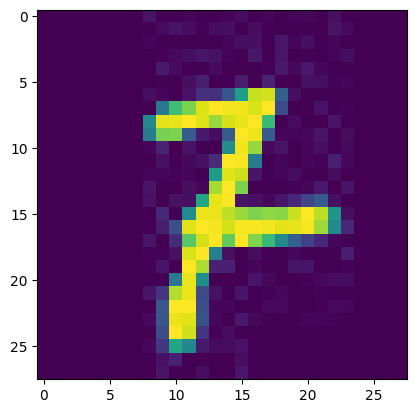

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  20,  62, 243, 255,
       251, 239, 253, 253, 251, 245, 246, 252, 218, 122,  28,   0,   0,
         0,   0], dtype=uint8)

In [40]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
example = Image.open("mnist_example.jpg")

# Display the image
plt.imshow(example)
plt.show()

# Convert the image to a numpy array
pixel_array = np.array(example)
pixel_array[16]

## Exercise 1. Building a convolutional neural network

### Data formatting

We'll download our data using a specific function in the `torchvision.datasets` submodule. This function will download the data into your working directory. We can also specify whether we want the cannonical `train` or `test` splits of the data, and since we want to represent these as tensors, we can use the `torchvision.transforms` submodule function `ToTensor()` to convert the data into the correct format.

Complete the code below to generate both a train and a test dataset, as well as corresponding dataloaders for training.

In [41]:
# Get train and test sets for the MNIST data using the torch package
import torch
import torchvision
from torchvision.transforms import ToTensor

torch.random.manual_seed(42)

# Download and load the training data
mnist_train = torchvision.datasets.MNIST(
    "./mnist_data", download=True, train=True, transform=ToTensor()
)
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

# Get the corresponding test data
mnist_test = torchvision.datasets.MNIST(
    "./mnist_data", download=True, train=False, transform=ToTensor()
)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

### Defining the CNN architecture

Now we can design our CNN to classify these images.

The key, new bits of code we will need to use are:

`torch.nn.Conv2d` - a 2D convolutional layer to create our feature maps

 * This function takes in a minimum of three arguments: the number of input channels (`in_channels`), the number of output channels (`out_channels`), and the kernel size (you guessed it...`kernel_size`!)
 * You can also modify the `stride` (default = 1) and amount of `padding` (default = 0). Notice, in the default implementation, as there is no padding there will be some reduction in the image size after each cross-correlation operation. If you want to downsample the image only through pooling, you can set `padding = 'same'` to keep the image size the same after the cross-correlation.
 * You can review the full documentation for this layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

`torch.nn.MaxPool2d` - a 2D pooling layer we can use to downsample our feature maps

 * For a given `kernel_size` and `stride`, this layer will take the maximum value in each `kernel_size` x `kernel_size` window and output it to the next layer
 * This operation has the effect of reducing the resolution of our feature maps
 * Note: as with dropout, this is a functional operation and so we only need to define this attribute once (and then can apply it multiple times in the forward pass)
 * The full documentation can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

We will then use fully connected layers (as per last week) at the end of our convolutions before making our final predictions.

### Building the neural network

Your task is to complete the below code to build a simple CNN with the following architecture:

1. Two convolutional layers. The first layer should yield 2 feature maps, and the second layer should yield 4 feature maps. You should use a kernel size of 3 for both layers, but prevent these cross-correlations from reducing the dimensionality of the inputs (using the `padding` argument)
2. Max pooling layers with a kernel size of 2 and stride of 2 to downsample the resolution of the image
3. Two fully connected layers with 64 and 32 nodes respectively
4. An output layer with 10 features (one for each digit)

You will need to *flatten* your convolutions prior to passing the data to the fully connected layers. Rather than using 'reshape' here, which would duplicate the objects in memory, we can use `torch.view`, which will also change the shape of the tensor but using the existing data (and thus preserving memory).

To calculate the number of input features to the first fully connected layer, you should consult the documentation for the `torch.nn.Conv2d` and `torch.nn.MaxPool2d` for the required formulas (or do it from first principles in your head!)

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 1, 2 because image black and white and I want 2 feature maps
        self.conv1 = torch.nn.Conv2d(1, 2, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(2, 4, kernel_size=3, padding=1)
        # get out 4 feature maps of shape 7x7

        self.fc1 = torch.nn.Linear(7*7*4,64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.out = torch.nn.Linear(32, 10)

        self.hidden_act = torch.nn.ReLU()
        # pool to half the images
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Your code here

        # convolution
        x = self.pool(self.hidden_act(self.conv1(x)))
        x = self.pool(self.hidden_act(self.conv2(x)))

        #flatten
        # -1 to assume input shape
        x = x.view(-1, 7*7*4)

        # MLP
        x = self.hidden_act(self.fc1(x))
        x = self.hidden_act(self.fc2(x))
        x = self.out(x)

        return x

    def predict_proba(self, x):
        return torch.nn.functional.softmax(self.forward(x), dim=1)

To test your model, we can take the very first training image example and pass it through our untrained model to check the output size:

In [ ]:
# Convert the img to a tensor and test the output of the CNN
img_tensor = mnist_train[0][0]
cnn = CNN()
output = cnn(img_tensor)
output

### Training the neural network

Finally, we will train the neural network using the MNIST data. We won't worry about a validation dataset today, because the runtimes will be so long we will only loop through our data twice!

Complete the code below to train the neural network. You will need to define a loss function and an optimizer, and then loop over the data to train the model.

You should use cross entropy loss and the `torch.optim.Adam` optimizer.

**Warning!** Always read the PyTorch documentation for the function you are using. In our discussions of multi-class classification, we defined the output activation as a softmax function (converting logits to probabilities for each class). But the cross entropy loss function in PyTorch already includes a softmax operation, so we should not apply the softmax function to the output of our neural network. If you added a softmax activation before, remove this line and rerun your model definition before proceeding.

  * If you want to get class probabilities, you could define a new method `predict_proba` that applies the softmax function to the output of your neural network (i.e. by calling `forward()` and then activating the results). This method would not be used during training, but could be useful for making predictions after training is complete. *You do not need to implement this now in order to complete these exercises*

Even though the number of feature maps is very small, the sheer quantity of training data means the code will take a while to run (approx. 3 minutes on a M1 Max MacBook Pro).

In [ ]:
cnn = CNN()

criterion = (
    torch.nn.CrossEntropyLoss()
)  # notice the loss function requires the output to be unnormalized logits (i.e. not softmax)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# Train the CNN
n_epochs = 2
cnn.train()
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = cnn(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch #{i}, Loss: {loss.item()}")

## Test time

Finally, we can assess how well our model performs on out-of-sample data using the test set and classification accuracy metric. Rather than worry too much about converting logits to probabilities, since the maximum logit will have the highest probability, we can just use `torch.max` to find the most likely class. This function returns both the maximum value and the index of the maximum value (we want the latter), and we apply this over the 1st dimension to get the most likely class for each image.

A little caveat: PyTorch is fantastic, but for some functions the documentation can be a bit lacking. So while you should always read it, you may also need to test it. Here, the `torch.max` [documentation](https://pytorch.org/docs/2.6/generated/torch.max.html#torch-max) simply states it 'returns the maximum value' but, as you'll see below, it returns *both* that value **and** the corresponding index of that value. So just be mindful of this as you implement novel features from this library.

Complete and run the code below:

In [ ]:
with torch.no_grad():
    cnn.eval()
    correct_count = 0
    for imgs, labels in testloader:
        # get logits for batch
        outputs = cnn(imgs)
        # get the predicted class
        _, predicted = torch.max(outputs, 1)
        correct_count += (predicted == labels).sum().item()

    print(f"Accuracy: {round(100*(correct_count/(len(testloader)*64)))}%")

## Exercise 3. MNIST (variational) autoeconder

Revisiting the autoencoders from the lecture, can you improve the reconstruction and also the sampling of new MNIST images? Options could e.g. be to increase the number of units in the bottleneck representation, adding convolutional layers, or further fully connected layers. You could also add structure by leveraging the knowledge that MNIST digits are grey-scale values between 0 and 1, and incorporate a sigmoid activation function in the output layer and a binary cross-entropy loss function.

In [42]:
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder layers
        self.e1 = nn.Linear(28 * 28, 256)
        self.e2 = nn.Linear(256, 128)
        self.e3 = nn.Linear(128, 64)
        # Instead of a single bottleneck layer, we have two heads for mu and logvar
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder layers
        self.d1 = nn.Linear(latent_dim, 64)
        self.d2 = nn.Linear(64, 128)
        self.d3 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 28 * 28)

        # Activation function
        self.hidden_act = nn.ReLU()

    def encode(self, x):
        # Pass through encoder layers
        x = self.hidden_act(self.e1(x))
        x = self.hidden_act(self.e2(x))
        x = self.hidden_act(self.e3(x))
        # Produce the parameters for the latent distribution
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Compute standard deviation and sample epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        # Return the sampled latent vector
        return mu + eps * std

    def decode(self, z):
        # Pass through decoder layers
        z = self.hidden_act(self.d1(z))
        z = self.hidden_act(self.d2(z))
        z = self.hidden_act(self.d3(z))
        z = self.out(z)
        return z

    def forward(self, x):
        # Encode the input to get mu and logvar
        mu, logvar = self.encode(x)
        # Sample a latent vector
        z = self.reparameterize(mu, logvar)
        # Decode the latent vector back to an image
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [53]:
# Instantiate and train

latent_dim = 5
n_epochs = 10

vae = VAE(latent_dim=latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# Training loop
vae.train()
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        # Flatten the images into vectors of size 28*28
        imgs_flat = imgs.view(-1, 28 * 28)
        # Forward pass through the VAE
        recon, mu, logvar = vae(imgs_flat)

        # Compute the reconstruction loss
        MSE = F.mse_loss(recon, imgs_flat, reduction="sum")

        # Compute the KL divergence loss for the prior of a standard normal distribution
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = MSE + KLD
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch #{i}, Loss: {loss.item()}")

Epoch 1/10, Batch #0, Loss: 5898.28564453125
Epoch 1/10, Batch #100, Loss: 3520.794677734375
Epoch 1/10, Batch #200, Loss: 3284.164794921875
Epoch 1/10, Batch #300, Loss: 3116.273681640625
Epoch 1/10, Batch #400, Loss: 2981.61865234375
Epoch 1/10, Batch #500, Loss: 2801.5009765625
Epoch 1/10, Batch #600, Loss: 2806.207275390625
Epoch 1/10, Batch #700, Loss: 2818.09912109375
Epoch 1/10, Batch #800, Loss: 2636.303955078125
Epoch 1/10, Batch #900, Loss: 2482.912109375
Epoch 2/10, Batch #0, Loss: 2477.523193359375
Epoch 2/10, Batch #100, Loss: 2519.532470703125
Epoch 2/10, Batch #200, Loss: 2544.82470703125
Epoch 2/10, Batch #300, Loss: 2512.999755859375
Epoch 2/10, Batch #400, Loss: 2398.091552734375
Epoch 2/10, Batch #500, Loss: 2351.3515625
Epoch 2/10, Batch #600, Loss: 2443.0498046875
Epoch 2/10, Batch #700, Loss: 2492.7919921875
Epoch 2/10, Batch #800, Loss: 2232.298828125
Epoch 2/10, Batch #900, Loss: 2149.59423828125
Epoch 3/10, Batch #0, Loss: 2278.050048828125
Epoch 3/10, Batch #1

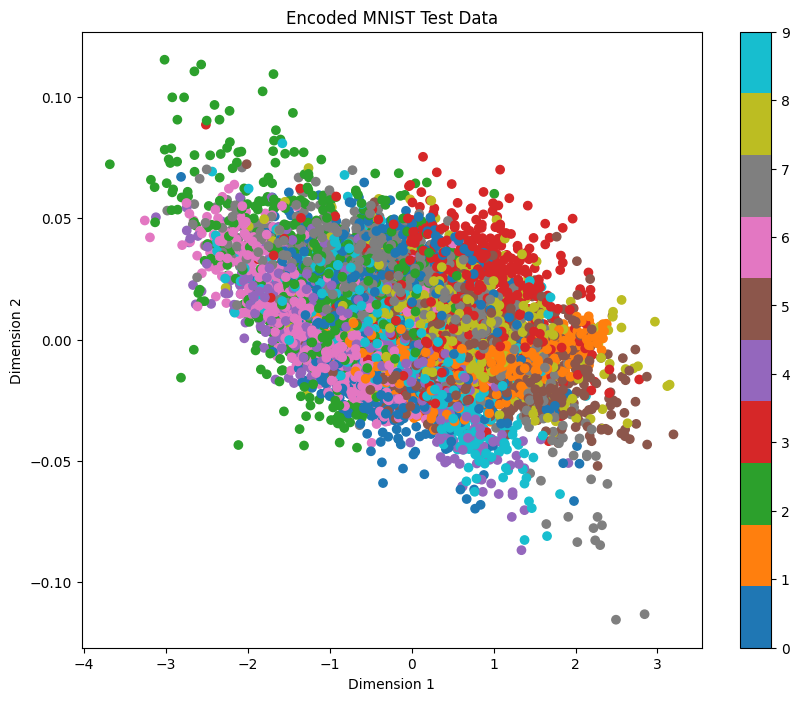

In [54]:
import matplotlib.pyplot as plt

encoded_imgs = []
labels_list = []

with torch.no_grad():
    vae.eval()
    for imgs, labels in testloader:
        mu, logvar = vae.encode(imgs.view(-1, 28 * 28))  # unpack the tuple
        encoded_imgs.append(mu)  # use the mean as the latent representation
        labels_list.append(labels)

# Concatenate all encoded images and labels
encoded_imgs = torch.cat(encoded_imgs)
labels_list = torch.cat(labels_list)

encoded_imgs = encoded_imgs.cpu().numpy()
labels_list = labels_list.cpu().numpy()

# Plot the encoded representations
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    encoded_imgs[:, 0], encoded_imgs[:, 1], c=labels_list, cmap="tab10"
)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded MNIST Test Data")
plt.show()

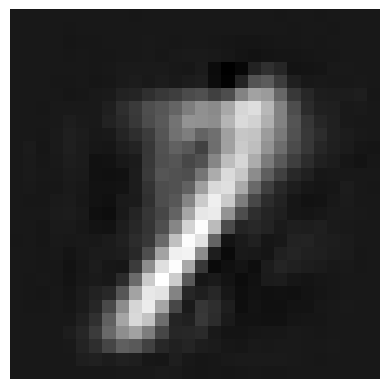

In [70]:
# Now we can sample from the latent space with a standard normal distribution

import torch
import matplotlib.pyplot as plt

# Sample a random latent vector from N(0,1) with latent dimension 2
latent_vector = torch.randn(1, latent_dim)

with torch.no_grad():
    vae.eval()
    generated = vae.decode(latent_vector)

# Reshape to 28x28 and display the generated image
generated_img = generated.view(28, 28).cpu().numpy()
plt.imshow(generated_img, cmap="gray")
plt.axis("off")
plt.show()